## Accessing Harmonized Global Biomass data on Azure

The Harmonized Global Biomass (HGB) dataset provides temporally consistent and harmonized global maps of aboveground and belowground biomass carbon density for the year 2010 at 300m resolution. The aboveground biomass map integrates land-cover specific, remotely sensed maps of woody, grassland, cropland, and tundra biomass. Input maps were amassed from the published literature and, where necessary, updated to cover the focal extent or time period. The belowground biomass map similarly integrates matching maps derived from each aboveground biomass map and land-cover specific empirical models. Aboveground and belowground maps were then integrated separately using ancillary maps of percent tree cover and landcover and a rule-based decision tree. Maps reporting the accumulated uncertainty of pixel-level estimates are also provided.

This notebook provides an example of accessing HGB data from blob storage on Azure, including (1) looking at the directory where data is stored, (2) loading the cloud optimized geotiff for a particular year, and (3) doing some simple processing and plotting of the data.


This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-hgb](http://aka.ms/ai4edata-hgb).

### Environment setup

In [4]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt 

storage_account_name = 'cpdataeuwest'
container = 'cpdata'
folder = 'raw/2010-harmonized-biomass/global/300m'
target_variable = 'aboveground' # aboveground, belowground

### View available data

In [2]:
fs = fsspec.get_filesystem_class('az')(account_name=storage_account_name)
fs.ls(path=f'{container}' + '/' + folder)

['cpdata/raw/2010-harmonized-biomass/global/300m/aboveground.tif',
 'cpdata/raw/2010-harmonized-biomass/global/300m/aboveground_uncertainty.tif',
 'cpdata/raw/2010-harmonized-biomass/global/300m/belowground.tif',
 'cpdata/raw/2010-harmonized-biomass/global/300m/belowground_uncertainty.tif']

### Load the variable of interest

In [5]:
da = xr.open_rasterio(f'https://{storage_account_name}.blob.core.windows.net/' +
                      f'{container}' + '/' + folder + '/' + target_variable + '.tif', 
                      chunks=dict(x=2560, y=2560))

# Transform our data array to a dataset by selecting the only data variable ('band')
# renaming it to something useful ('biomass')
ds = da.to_dataset(dim='band').rename({1: 'biomass'})
ds

<xarray.Dataset>
Dimensions:  (x: 129600, y: 52201)
Coordinates:
  * y        (y) float64 84.0 84.0 83.99 83.99 ... -60.99 -61.0 -61.0 -61.0
  * x        (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0 180.0
Data variables:
    biomass  (y, x) uint16 dask.array<chunksize=(2560, 2560), meta=np.ndarray>
Attributes:
    transform:           (0.00277777777777778, 0.0, -180.00000000000006, 0.0,...
    crs:                 +init=epsg:4326
    res:                 (0.00277777777777778, 0.00277777777777778)
    is_tiled:            1
    nodatavals:          (nan,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    DataType:            Generic
    OVR_RESAMPLING_ALG:  NEAREST

### Plot global aboveground biomass

In [6]:
# Coarsen by 100x on each dimension to get to a reasonable plotting size 
factor = 100
coarse = ds.biomass.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()

In [9]:
coarse.shape

(522, 1296)

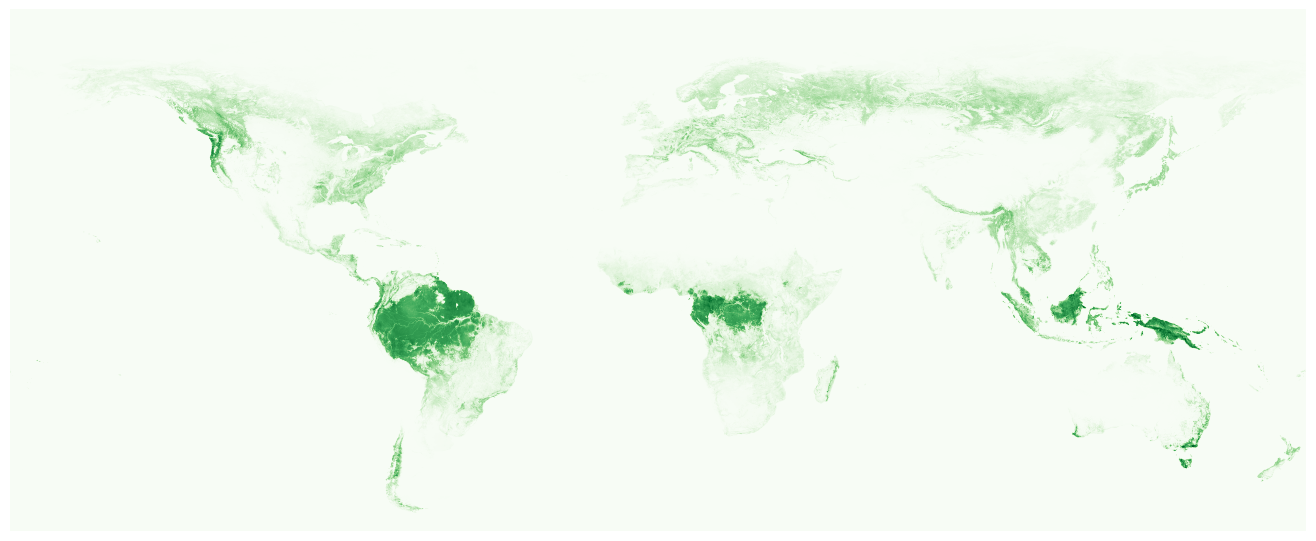

In [17]:
w = coarse.shape[1]; h=coarse.shape[0]; dpi = 100
fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi);
ax = plt.Axes(fig,[0., 0., 1., 1.])
ax.set_axis_off(); fig.add_axes(ax)
coarse.plot(cmap='Greens',add_colorbar=False)
plt.show();